# 9章 CIFAR10を使った画像認識

In [1]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 1
pdf_base = 'pdf-09-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

def graph_pdf(g):
    global pdf_ind, pdf_base
    fnbase = f'{pdf_base}{pdf_ind:02d}'
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fnbase)
    g.render(fnbase, view=False)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

In [2]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [4]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

### GPUチェック

In [6]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNNの処理概要

In [7]:
data_root = './data'

# サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [ ]:
# ダウンロードトラブルに対する回避策
# 普段は実行しなくていいです。
# 上のセルでエラーが発生したらこのセルを実行し、その後で上のセルを再実行して下さい。

datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

In [8]:
# 対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

# biasを0に
nn.init.constant_(conv1.bias, 0.0)

# weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [9]:
# 手書き数字に3回畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

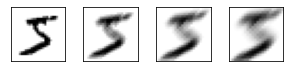

In [10]:
# 結果の画面表示

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 PyTorchでのCNN実装

### nn.Conv2d とnn.MaxPool2d

In [11]:
# CNN前半部分 レイヤー関数の定義

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [12]:
# conv1の確認
print(conv1)

# conv1の内部変数のshape確認
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [13]:
# conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

# waeight[0]のshapeと値の確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[ 0.16825  0.18268 -0.14198]
  [ 0.08288 -0.04334 -0.02234]
  [ 0.07717 -0.10904 -0.16084]]

 [[-0.18844  0.06695 -0.02706]
  [-0.14889 -0.02639 -0.09269]
  [ 0.05851  0.10009 -0.09753]]

 [[ 0.15158 -0.19212 -0.03092]
  [-0.17018  0.02517  0.06262]
  [-0.05313  0.18821  0.0636 ]]]


In [14]:
# ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [15]:
# CNNの前半部分をシミュレーションする

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [16]:
# それぞれのshapeの確認

print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [17]:
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [18]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [19]:
# 関数定義
flatten = nn.Flatten()

# 動作テスト
outputs2 = flatten(outputs)

# 結果確認
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.4 共通関数の定義

### eval_loss 損失関数計算用

In [20]:
# 損失関数値計算用
def eval_loss(loader, device, net, criterion):
  
    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)

    #  損失値の計算
    loss = criterion(outputs, labels)

    return loss

### fit 学習用

In [21]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # 重み変更
            optimizer.step()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            train_acc += (predicted == labels).sum()

            # 訓練データに対する損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 検証データに対する損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history 学習ログ解析用

In [22]:
# 学習ログ解析

def evaluate_history(history):
    #損失関数値と精度の確認
    print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失関数)
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失関数値')
    plt.title('学習曲線(損失関数)')
    plt.legend()
    create_pdf(plt)
    plt.show()

    # 学習曲線の表示 (精度)
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    create_pdf(plt)
    plt.show()

### show_predict_result 予測結果表示用

In [23]:
# 予測結果標示
def show_predict_result(net, loader, classes):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)
    predicted = torch.max(outputs,1)[1]
    images = images.to('cpu')

    # 最初の50個の表示
    plt.figure(figsize=(11, 6))
    for i in range(50):
        ax = plt.subplot(5, 10, i + 1)
        image = images[i].numpy()
        label_name = classes[labels[i]]
        predicted_name = classes[predicted[i]]
        img = np.transpose(image, (1, 2, 0))
        img2 = (img + 1)/2 
        plt.imshow(img2)
        if label_name == predicted_name:
            c = 'k'
        else:
            c = 'b'
        ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    create_pdf(plt)
    plt.show()

### show_images_labels
イメージとラベルの表示

In [24]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測値の計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初の50個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
          predicted_name = classes[predicted[i]]
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        else:
          ax.set_title(label_name, fontsize=20)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow((img + 1)/2)
        ax.set_axis_off()
    plt.show()


### torch_seed 乱数固定用

In [25]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## 9.6 データ準備

In [26]:
# transformの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [27]:
# データ取得用関数 DataSet

data_root = './data'

# 訓練データセット 1次元版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1次元版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3次元版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3次元版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの確認

In [28]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [29]:
# DataLoaderの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [30]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


In [32]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


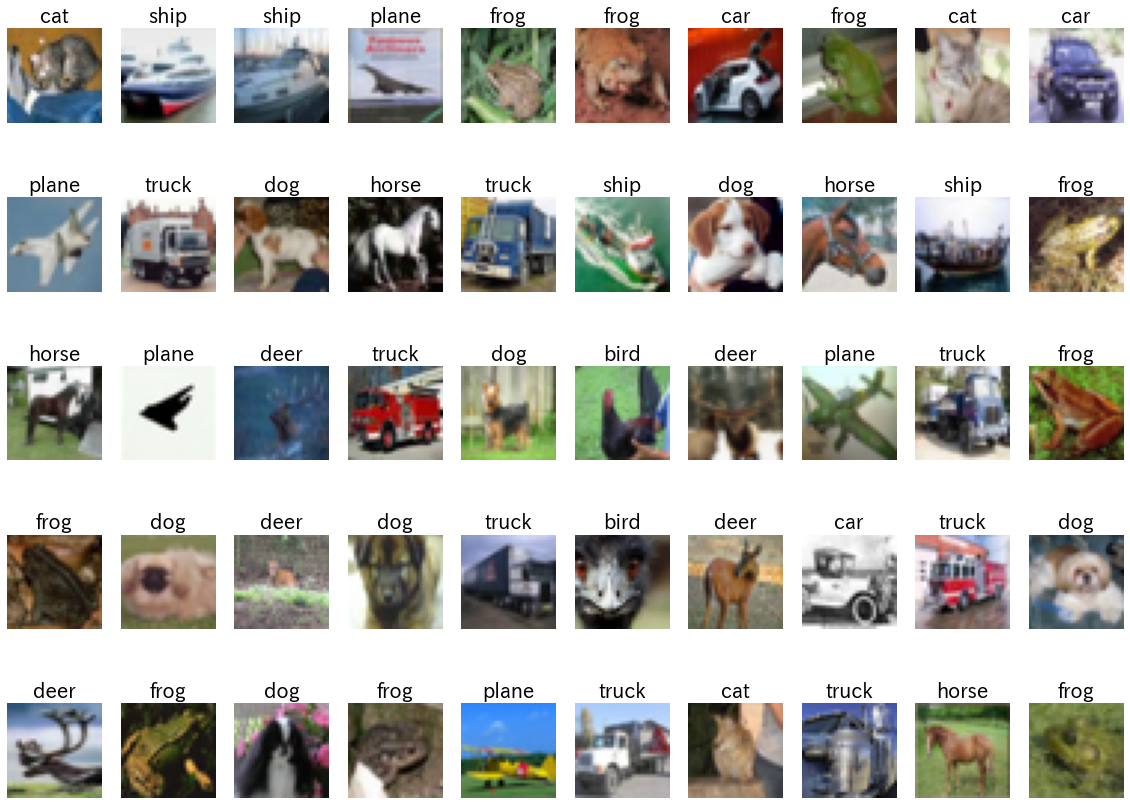

In [35]:
# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, device)

## 9.7 モデル定義(全結合版)

### 学習用パラメータ設定

In [36]:
# 入力次元数 今回は3*32*32=3072
n_input = image.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels.data.numpy())))

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [37]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### モデルインスタンスの生成とGPUの割り当て

In [38]:
# インスタンスの生成
net = Net(n_input, n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [39]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [40]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.45
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

## 9.8 結果(全結合版)

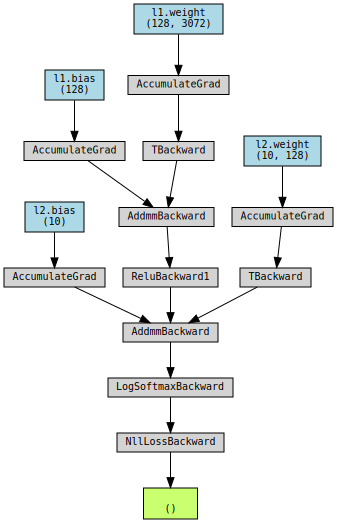

In [41]:
# 損失の計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失関数のグラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 学習

In [43]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)


Epoch [1/50], loss: 0.01950 acc: 0.32114 val_loss: 0.01795, val_acc: 0.37780



Epoch [2/50], loss: 0.01739 acc: 0.39440 val_loss: 0.01685, val_acc: 0.41880



Epoch [3/50], loss: 0.01655 acc: 0.42380 val_loss: 0.01624, val_acc: 0.43640



Epoch [4/50], loss: 0.01602 acc: 0.44212 val_loss: 0.01583, val_acc: 0.45120



Epoch [5/50], loss: 0.01564 acc: 0.45510 val_loss: 0.01556, val_acc: 0.45980



Epoch [6/50], loss: 0.01532 acc: 0.46528 val_loss: 0.01529, val_acc: 0.47010



Epoch [7/50], loss: 0.01505 acc: 0.47714 val_loss: 0.01509, val_acc: 0.47350



Epoch [8/50], loss: 0.01480 acc: 0.48688 val_loss: 0.01498, val_acc: 0.48080



Epoch [9/50], loss: 0.01457 acc: 0.49662 val_loss: 0.01476, val_acc: 0.48740



Epoch [10/50], loss: 0.01436 acc: 0.50232 val_loss: 0.01465, val_acc: 0.48990



Epoch [11/50], loss: 0.01416 acc: 0.51230 val_loss: 0.01449, val_acc: 0.49180



Epoch [12/50], loss: 0.01397 acc: 0.51942 val_loss: 0.01441, val_acc: 0.49840



Epoch [13/50], loss: 0.01378 acc: 0.52328 val_loss: 0.01428, val_acc: 0.50390



Epoch [14/50], loss: 0.01360 acc: 0.53098 val_loss: 0.01417, val_acc: 0.50630



Epoch [15/50], loss: 0.01344 acc: 0.53748 val_loss: 0.01410, val_acc: 0.50790



Epoch [16/50], loss: 0.01327 acc: 0.54388 val_loss: 0.01402, val_acc: 0.51280



Epoch [17/50], loss: 0.01311 acc: 0.54884 val_loss: 0.01396, val_acc: 0.51290



Epoch [18/50], loss: 0.01296 acc: 0.55314 val_loss: 0.01388, val_acc: 0.51640



Epoch [19/50], loss: 0.01283 acc: 0.56006 val_loss: 0.01379, val_acc: 0.52010



Epoch [20/50], loss: 0.01268 acc: 0.56478 val_loss: 0.01377, val_acc: 0.51880



Epoch [21/50], loss: 0.01255 acc: 0.57140 val_loss: 0.01371, val_acc: 0.51850



Epoch [22/50], loss: 0.01241 acc: 0.57284 val_loss: 0.01368, val_acc: 0.51860



Epoch [23/50], loss: 0.01229 acc: 0.57906 val_loss: 0.01363, val_acc: 0.52230



Epoch [24/50], loss: 0.01216 acc: 0.58370 val_loss: 0.01356, val_acc: 0.52540



Epoch [25/50], loss: 0.01205 acc: 0.58890 val_loss: 0.01350, val_acc: 0.52830



Epoch [26/50], loss: 0.01193 acc: 0.59152 val_loss: 0.01344, val_acc: 0.53050



Epoch [27/50], loss: 0.01181 acc: 0.59804 val_loss: 0.01347, val_acc: 0.52590



Epoch [28/50], loss: 0.01170 acc: 0.60062 val_loss: 0.01341, val_acc: 0.52940



Epoch [29/50], loss: 0.01159 acc: 0.60430 val_loss: 0.01340, val_acc: 0.52640



Epoch [30/50], loss: 0.01148 acc: 0.60952 val_loss: 0.01342, val_acc: 0.53080



Epoch [31/50], loss: 0.01138 acc: 0.61274 val_loss: 0.01335, val_acc: 0.53170



Epoch [32/50], loss: 0.01127 acc: 0.61760 val_loss: 0.01340, val_acc: 0.52700



Epoch [33/50], loss: 0.01117 acc: 0.61996 val_loss: 0.01338, val_acc: 0.53120



Epoch [34/50], loss: 0.01107 acc: 0.62514 val_loss: 0.01336, val_acc: 0.52990



Epoch [35/50], loss: 0.01098 acc: 0.62726 val_loss: 0.01340, val_acc: 0.52510



Epoch [36/50], loss: 0.01088 acc: 0.63028 val_loss: 0.01334, val_acc: 0.53310



Epoch [37/50], loss: 0.01079 acc: 0.63470 val_loss: 0.01332, val_acc: 0.53160



Epoch [38/50], loss: 0.01070 acc: 0.63674 val_loss: 0.01341, val_acc: 0.52840



Epoch [39/50], loss: 0.01061 acc: 0.64082 val_loss: 0.01337, val_acc: 0.52910



Epoch [40/50], loss: 0.01052 acc: 0.64202 val_loss: 0.01339, val_acc: 0.53010



Epoch [41/50], loss: 0.01043 acc: 0.64724 val_loss: 0.01339, val_acc: 0.52730



Epoch [42/50], loss: 0.01035 acc: 0.65008 val_loss: 0.01336, val_acc: 0.53120



Epoch [43/50], loss: 0.01027 acc: 0.65230 val_loss: 0.01342, val_acc: 0.53000



Epoch [44/50], loss: 0.01018 acc: 0.65602 val_loss: 0.01340, val_acc: 0.53000



Epoch [45/50], loss: 0.01010 acc: 0.65922 val_loss: 0.01344, val_acc: 0.52930



Epoch [46/50], loss: 0.01001 acc: 0.66152 val_loss: 0.01343, val_acc: 0.53030



Epoch [47/50], loss: 0.00994 acc: 0.66530 val_loss: 0.01346, val_acc: 0.52900



Epoch [48/50], loss: 0.00987 acc: 0.66750 val_loss: 0.01350, val_acc: 0.52740



Epoch [49/50], loss: 0.00979 acc: 0.66906 val_loss: 0.01342, val_acc: 0.53450



Epoch [50/50], loss: 0.00971 acc: 0.67302 val_loss: 0.01350, val_acc: 0.52800


### 評価

初期状態: 損失関数: 0.01795 精度: 0.37780
最終状態: 損失関数: 0.01350 精度: 0.52800
pdf-09-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

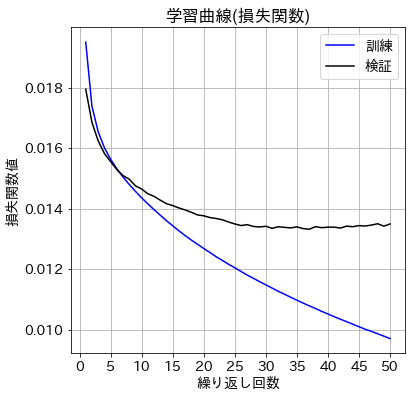

pdf-09-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

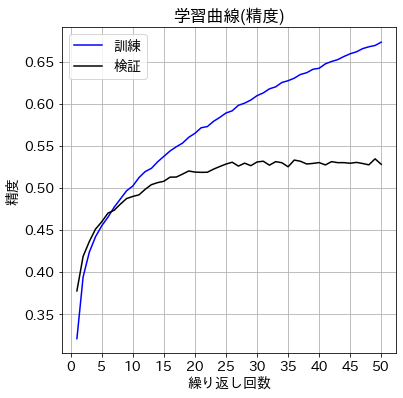

In [44]:
# 評価

evaluate_history(history)

## 9.9 モデル定義(CNN版)

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.classifier1 = nn.Linear(6272, n_hidden)
    self.classifier2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.classifier1,
       self.relu,
       self.classifier2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### モデルインスタンスの生成

In [ ]:
# インスタンスの生成
net = CNN(n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [ ]:
# モデルの概要表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier1): Linear(in_features=6272, out_features=128, bias=True)
  (classifier2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 1,628,756
Trainable params: 1,628,756
Non-trainable params: 0
Total mult-adds (G): 2.60
Input size (MB): 1.23
Forward/ba

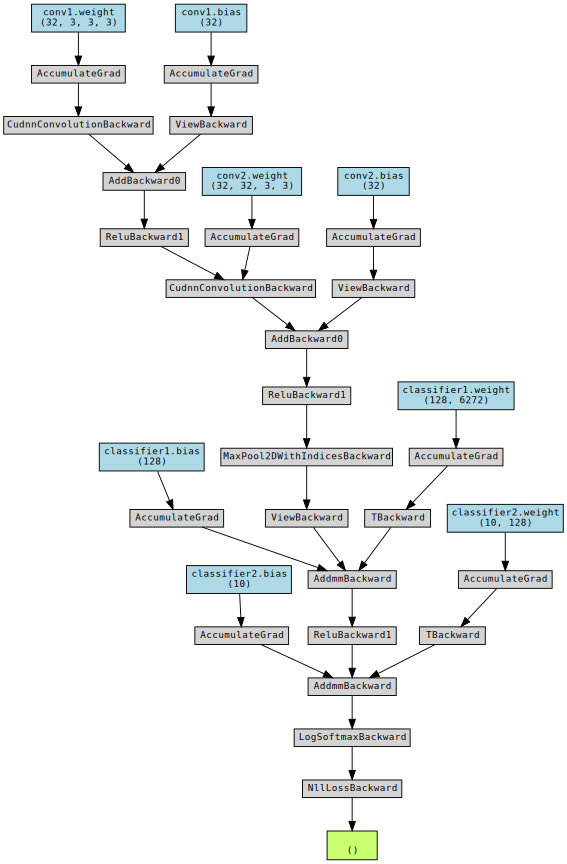

In [ ]:
# 損失の計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失関数の計算グラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 結果(CNN版)

### 学習

In [ ]:
# 乱数初期化
torch_seed()

# 初期化
net = CNN(n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)


Epoch [1/50], loss: 0.02082 acc: 0.25942 val_loss: 0.01860, val_acc: 0.35140



Epoch [2/50], loss: 0.01779 acc: 0.37294 val_loss: 0.01681, val_acc: 0.40660



Epoch [3/50], loss: 0.01610 acc: 0.43080 val_loss: 0.01528, val_acc: 0.46050



Epoch [4/50], loss: 0.01484 acc: 0.47398 val_loss: 0.01425, val_acc: 0.49320



Epoch [5/50], loss: 0.01406 acc: 0.49906 val_loss: 0.01396, val_acc: 0.50320



Epoch [6/50], loss: 0.01349 acc: 0.52046 val_loss: 0.01339, val_acc: 0.52190



Epoch [7/50], loss: 0.01300 acc: 0.53966 val_loss: 0.01284, val_acc: 0.54550



Epoch [8/50], loss: 0.01253 acc: 0.55714 val_loss: 0.01264, val_acc: 0.54770



Epoch [9/50], loss: 0.01205 acc: 0.57566 val_loss: 0.01220, val_acc: 0.56510



Epoch [10/50], loss: 0.01157 acc: 0.59360 val_loss: 0.01220, val_acc: 0.56340



Epoch [11/50], loss: 0.01116 acc: 0.60876 val_loss: 0.01162, val_acc: 0.58270



Epoch [12/50], loss: 0.01074 acc: 0.62212 val_loss: 0.01135, val_acc: 0.59670



Epoch [13/50], loss: 0.01036 acc: 0.63722 val_loss: 0.01111, val_acc: 0.61210



Epoch [14/50], loss: 0.00997 acc: 0.65120 val_loss: 0.01095, val_acc: 0.61390



Epoch [15/50], loss: 0.00957 acc: 0.66424 val_loss: 0.01065, val_acc: 0.62740



Epoch [16/50], loss: 0.00920 acc: 0.67834 val_loss: 0.01048, val_acc: 0.63270



Epoch [17/50], loss: 0.00883 acc: 0.69016 val_loss: 0.01033, val_acc: 0.64050



Epoch [18/50], loss: 0.00847 acc: 0.70658 val_loss: 0.01023, val_acc: 0.64100



Epoch [19/50], loss: 0.00805 acc: 0.72098 val_loss: 0.01008, val_acc: 0.64900



Epoch [20/50], loss: 0.00773 acc: 0.73128 val_loss: 0.01010, val_acc: 0.65180



Epoch [21/50], loss: 0.00733 acc: 0.74582 val_loss: 0.00982, val_acc: 0.66250



Epoch [22/50], loss: 0.00703 acc: 0.75536 val_loss: 0.00996, val_acc: 0.65800



Epoch [23/50], loss: 0.00666 acc: 0.76924 val_loss: 0.01043, val_acc: 0.64450



Epoch [24/50], loss: 0.00634 acc: 0.78150 val_loss: 0.01020, val_acc: 0.65630



Epoch [25/50], loss: 0.00598 acc: 0.79366 val_loss: 0.01004, val_acc: 0.66510



Epoch [26/50], loss: 0.00566 acc: 0.80574 val_loss: 0.01098, val_acc: 0.64270



Epoch [27/50], loss: 0.00534 acc: 0.81714 val_loss: 0.01019, val_acc: 0.66670



Epoch [28/50], loss: 0.00503 acc: 0.82774 val_loss: 0.01043, val_acc: 0.66600



Epoch [29/50], loss: 0.00468 acc: 0.84266 val_loss: 0.01045, val_acc: 0.67000



Epoch [30/50], loss: 0.00435 acc: 0.85418 val_loss: 0.01094, val_acc: 0.65760



Epoch [31/50], loss: 0.00403 acc: 0.86516 val_loss: 0.01110, val_acc: 0.65960



Epoch [32/50], loss: 0.00375 acc: 0.87522 val_loss: 0.01176, val_acc: 0.64750



Epoch [33/50], loss: 0.00344 acc: 0.88780 val_loss: 0.01227, val_acc: 0.64390



Epoch [34/50], loss: 0.00315 acc: 0.89602 val_loss: 0.01204, val_acc: 0.65550



Epoch [35/50], loss: 0.00283 acc: 0.90882 val_loss: 0.01234, val_acc: 0.66330



Epoch [36/50], loss: 0.00262 acc: 0.91714 val_loss: 0.01270, val_acc: 0.66350



Epoch [37/50], loss: 0.00233 acc: 0.92640 val_loss: 0.01340, val_acc: 0.65440



Epoch [38/50], loss: 0.00209 acc: 0.93674 val_loss: 0.01357, val_acc: 0.65220



Epoch [39/50], loss: 0.00181 acc: 0.94604 val_loss: 0.01391, val_acc: 0.65550



Epoch [40/50], loss: 0.00163 acc: 0.95326 val_loss: 0.01509, val_acc: 0.64450



Epoch [41/50], loss: 0.00146 acc: 0.95972 val_loss: 0.01472, val_acc: 0.65310



Epoch [42/50], loss: 0.00114 acc: 0.97132 val_loss: 0.01597, val_acc: 0.65140



Epoch [43/50], loss: 0.00104 acc: 0.97482 val_loss: 0.01581, val_acc: 0.65740



Epoch [44/50], loss: 0.00077 acc: 0.98564 val_loss: 0.01671, val_acc: 0.65720



Epoch [45/50], loss: 0.00067 acc: 0.98810 val_loss: 0.01678, val_acc: 0.65990



Epoch [46/50], loss: 0.00060 acc: 0.98996 val_loss: 0.01803, val_acc: 0.65010



Epoch [47/50], loss: 0.00092 acc: 0.98406 val_loss: 0.01705, val_acc: 0.65760



Epoch [48/50], loss: 0.00045 acc: 0.99492 val_loss: 0.01772, val_acc: 0.66230



Epoch [49/50], loss: 0.00029 acc: 0.99816 val_loss: 0.01831, val_acc: 0.66380



Epoch [50/50], loss: 0.00023 acc: 0.99876 val_loss: 0.01874, val_acc: 0.66360


### 評価

初期状態: 損失関数: 0.01860 精度: 0.35140
最終状態: 損失関数: 0.01874 精度: 0.66360
pdf-09-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

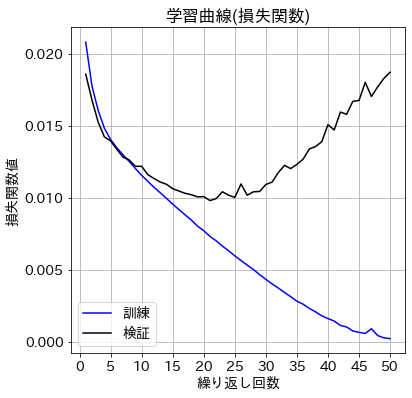

pdf-09-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

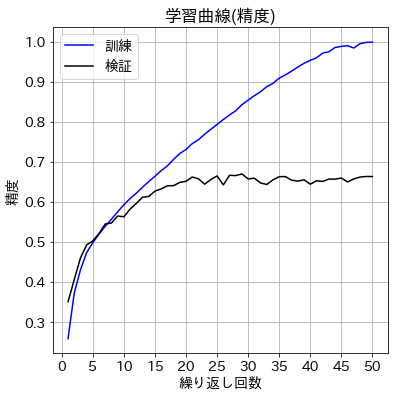

In [ ]:
# 評価

evaluate_history(history2)

pdf-09-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

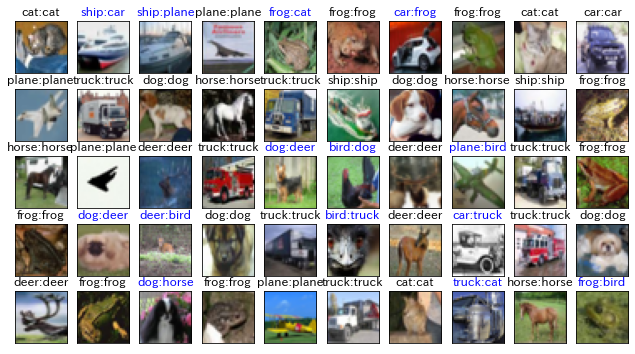

In [ ]:
# 最初の50個の表示

show_images_labels(test_loader3, classes, net, device)
#show_predict_result(net, test_loader2, classes)

In [ ]:
# 初期化
net = CNN(n_output, n_hidden).to(device)

# 学習率
lr = 0.01

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10

# 評価結果記録用
history3 = np.zeros((0,5))

In [ ]:
# 学習

history3 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history3)


Epoch [1/10], loss: 0.01666 acc: 0.39978 val_loss: 0.01330, val_acc: 0.52780



Epoch [2/10], loss: 0.01203 acc: 0.57088 val_loss: 0.01100, val_acc: 0.60800



Epoch [3/10], loss: 0.00975 acc: 0.65670 val_loss: 0.00984, val_acc: 0.65910



Epoch [4/10], loss: 0.00810 acc: 0.71434 val_loss: 0.00915, val_acc: 0.68070



Epoch [5/10], loss: 0.00683 acc: 0.76046 val_loss: 0.00912, val_acc: 0.68670



Epoch [6/10], loss: 0.00555 acc: 0.80512 val_loss: 0.00944, val_acc: 0.69030



Epoch [7/10], loss: 0.00438 acc: 0.84820 val_loss: 0.01044, val_acc: 0.68210



Epoch [8/10], loss: 0.00334 acc: 0.88348 val_loss: 0.01123, val_acc: 0.67930



Epoch [9/10], loss: 0.00235 acc: 0.91846 val_loss: 0.01304, val_acc: 0.67720



Epoch [10/10], loss: 0.00165 acc: 0.94412 val_loss: 0.01425, val_acc: 0.68140
